# Brief 14 - Classification d'images  
Ressource:
* https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
* https://scikit-image.org/docs/stable/auto_examples/
* https://pythonexamples.org/python-pillow/
* https://learnopencv.com/histogram-of-oriented-gradients/

Réponse au brief:

* https://kapernikov.com/tutorial-image-classification-with-scikit-learn/


## 1 - Données:  
Les données proviennent du Dataset:
    ​ https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip
    
**La classe nature a été supprimées**


## 2 - Fonctions de manipulation d'images.
* lecture
* redimensionner les images
* stocker les données dans un dictionnaire contenant les images, les étiquettes (animal), les noms de fichiers originaux et une description.
  
Les images elles-mêmes seront stockées sous forme de tableaux numpy contenant leurs valeurs RVB. Le dictionnaire sera enregistré dans un fichier pickle à l'aide de la librairie joblib. La structure des données sera basée sur celle utilisée pour les ensembles de données de test dans scikit-learn.

In [1]:
import numpy as np
import pandas as pds
import os 
import random
import copy

import joblib

import skimage
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import rescale, resize
from skimage import data, color

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB


import matplotlib.pyplot as plt

from collections import Counter

import sys
sys.path.append("./librairie")
import b17fonctions
 
#----------------------------------- Variables globales ----------------------------------------------
#data = dict()
#data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
#data['label'] = []
#data['filename'] = []
#data['data'] = []

d_DATA={'description': [],'label': [], 'filename': [],'data': []}
LARGEUR= 100 # Tester sur des format image plus large, 120 ?
HAUTEUR= LARGEUR

### Note:  
Un f-string convertit automatiquement les échappements avec des backslashs comme par exemple : \n , \", \t, etc. Donc si on ne veut pas que python interprète ces échappements il faut utiliser les raw string en ecrivant r avant la chaine de caractères et si on veut utiliser des raw f-strings il faut mettre fr.

In [2]:
# les f strings: 
#  Un string convertit automatiquement les échappements avec des backslashs comme par exemple : \n , \", \t,...
#  si on utilise une "raw string" python n'interprète ces échappements.

data_path = fr'{os.getenv("HOME")}/Documents/brief/brief14-Classification_Images/data/AnimalFace/Image'
l_rep= os.listdir(data_path) # Liste contenant le nom de tout les sous répertoires qui contiennent les images

print(f"Répertoires contenant les différents images:\n{l_rep}")

Répertoires contenant les différents images:
['PigHead', 'BearHead', 'WolfHead', 'RabbitHead', 'ChickenHead', 'PandaHead', 'HumanHead', 'PigeonHead', 'EagleHead', 'CatHead', 'TigerHead', 'SheepHead', 'ElephantHead', 'DeerHead', 'MouseHead', 'MonkeyHead', 'DogHead', 'CowHead', 'DuckHead', 'LionHead']


### Prise en main de la fonction resize  
#### **Mise en évidence d'une déformation due à la fonction resize**  
Si la photo n'est pas de format carré, la fonction resize va générer une déformation de l'image. Ceci pourrait poser un problème puisque l'algo fonctionne sur une détection de forme.  
On note cependant qu'une **majorité de photos** semble être de **forme carré** sauf pour les humains ou le format "paysage" est majoritaire.  
<span style="color:blue">
On pourrait faire un programme dédié aux photos en s'assurant:</br>
    - qu'elles soient au bon format, et en "retaillant" les photos sous un format carré sans déformation. Pour se faire, on prend la dimension la plus petite, on centre la dimension sur l'autre coté de la photo et on "découpe".</br>
    - qu'elle soit de bonne qualité</br>
    - nommée la photo avec son libellé (ours_0001.jpg par exemple)</br>
Utilisé la bibliothèque tkinter pour faire ce programme... sympa à développer mais ultérieurement!</br>
</span> 
  
<span style="color:red">
La photo exemple et prise dans le dataset me semble déformée (écrasé)...! Il faudrait analyser de plus près le jeux de donnée.</br>
</span> 

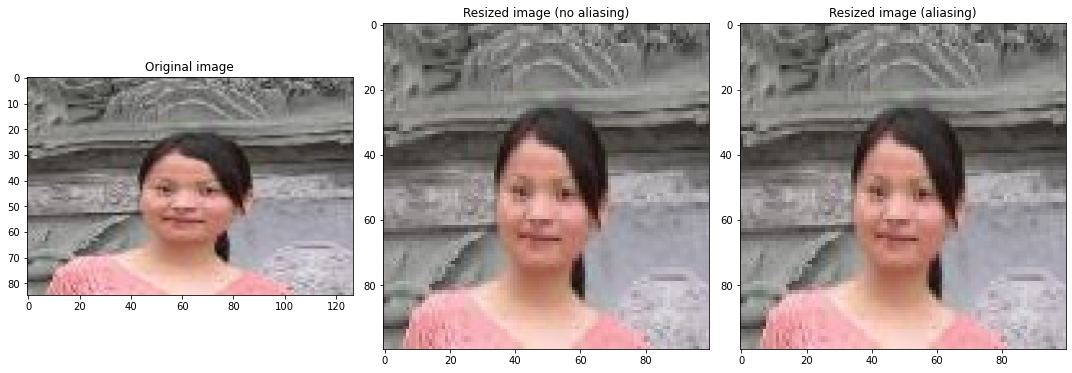

In [3]:
# Image provenant du dataset pour mettre en lumière pb éventuel
img = imread(os.path.join("/home/jpphi/Documents/brief/brief14-Classification_Images/", "img3_testdeform.jpg"))
img_resized = resize(img, (LARGEUR, HAUTEUR), anti_aliasing=True)
img_resized_aafalse= resize(img, (LARGEUR, HAUTEUR), anti_aliasing= False)

# Création de l'espace d'affichage
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))

axes[0].imshow(img, cmap='BrBG')
axes[0].set_title("Original image")

axes[1].imshow(img_resized, cmap='BrBG')
axes[1].set_title("Resized image (no aliasing)")

axes[2].imshow(img_resized_aafalse, cmap='BrBG')
axes[2].set_title("Resized image (aliasing)")

#axes[0].set_xlim(0, 512)
#axes[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()

### **Mise en évidence de potentiel problème avec la fonction resize**. La np-array retournée par resize n'a pas des nombres compris entre 0 et 255 comme je m'y attendais (norme rgb). Problème détecté trop tard, pas le temps de m'y pencher.

In [4]:
# Étrange, la fonction resize ne renvoi pas une np-array au standard rgb (0-255) mais des flottants (0-1) !!!
print(img_resized.max(), img_resized.min()) 

0.996078431372549 0.009546568627453114


### Fonction de découpe d'images.
**Intégrée au fichier /librairie/b17fonction.py**

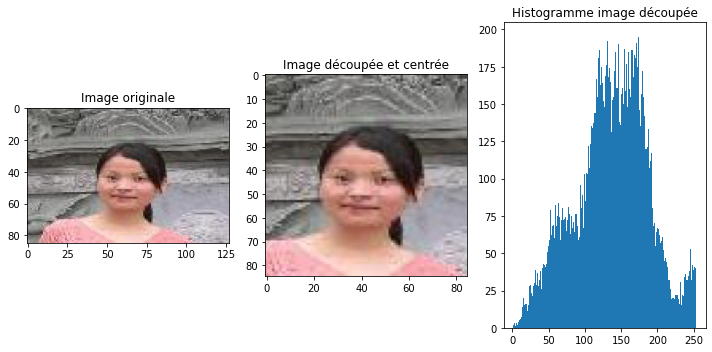

Shape image originale: (85, 127, 3)
Shape image découpée: (85, 85, 3)


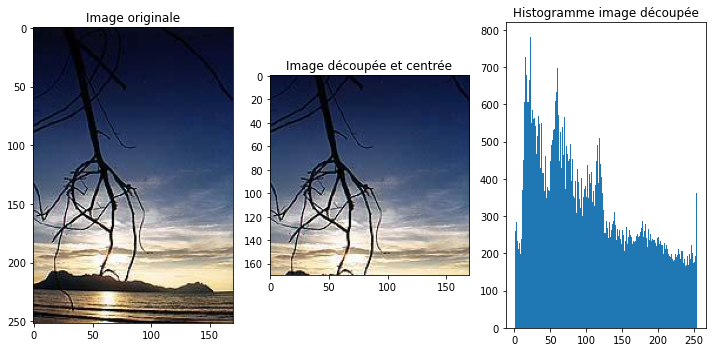

Shape image originale: (252, 170, 3)
Shape image découpée: (170, 170, 3)


In [5]:
imgpy = imread(os.path.join("/home/jpphi/Documents/brief/brief14-Classification_Images/", "img3_testdeform.jpg"))
imgpt = imread(os.path.join("/home/jpphi/Documents/brief/brief14-Classification_Images/", "img4_testdeforme.jpg"))

# découpe d'image

for image in (imgpy, imgpt):
    b17fonctions.decimg(image, affiche= True)


### Fonction contraste  
Pour améliorer et facilité la découpe des formes nous pourrions modifier le contraste. D'autres traitements d'image pourraient être également envisagé.  
Ressources:  
* https://openclassrooms.com/fr/courses/5060661-initiez-vous-aux-traitements-de-base-des-images-numeriques/5217291-concevez-des-operations-morphologiques-de-haut-niveau

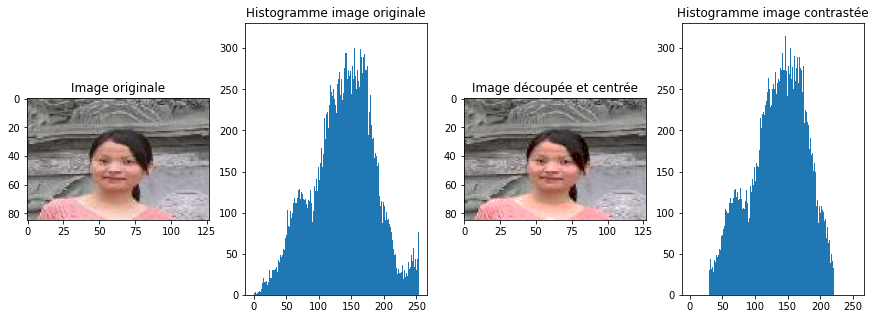

In [6]:
imgpy = imread(os.path.join("/home/jpphi/Documents/brief/brief14-Classification_Images/", "img3_testdeform.jpg"))
imgct= b17fonctions.imgcont(imgpy, affiche= True)

### Redimentionnement du jeux d'image  
**Attention au temps d'exécution!**  
  
**"cat1060a.bmp" est ignoré**.  
  
**dog000590a.jpg n'est pas en rgb mais en noir et blanc. Ce qui cause un plantage par la suite.**  
  
**Attention au fichier pickel. Faire un clear du kernel car reste en mémoire et risque de concaténation des données**  
  
<span style="color:blue">
On pourrait ressencé tout les fichiers images qui ne sont pas en jpg ou en png et les convertir.</br></br>
</span>  
  
  
<span style="color:blue">
L'idée de labelliser les images dans les métadonnéees du jpg ou du png a été envigé. La manipulation de ces métadonnées est difficile (impossible de rajouter un champ, réupération et enregistrment sous forme binaire,... l'opération est rendu complexe.</br>
Une idée plus simple serait de renommer les images avec ce format: "NomAnimal"_numero. L'utilisation de la fonction "split" sur "_" permettrait de recupérer facilement le label.
</span>  


In [7]:
# Pas de contraste, pas de mise en carré, taille 80 x 80

#['BearHead'] # pour test

largeur, hauteur= (80,80)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur)

In [8]:
# Pas de contraste, pas de mise en carré, taille 120 x 120
largeur, hauteur= (120,120)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur)

In [9]:
# Pas de contraste, mise en carré, taille 80 x 80

largeur, hauteur= (80,80)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur,recadrer= True)

In [10]:
# Pas de contraste, mise en carré, taille 120 x 120

largeur, hauteur= (120,120)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur,recadrer= True)

In [11]:
# contraste, mise en carré, taille 80 x 80

largeur, hauteur= (80,80)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur,recadrer= True, contraste= (30,220))

In [12]:
# contraste, mise en carré, taille 80 x 80

largeur, hauteur= (120,120)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur,recadrer= True, contraste= (30,220))

In [13]:
# contraste, pas de mise en carré, taille 80 x 80

largeur, hauteur= (80,80)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur,recadrer= False, contraste= (30,220))


In [14]:
# contraste, pas de mise en carré, taille 80 x 80

largeur, hauteur= (120,120)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur,recadrer= False, contraste= (30,220))


### On vas générer un pickel avec des images noir et blanc pour tester un classifier sans faire de hog

In [15]:
# Pas de contraste, mise en carré, taille 120 x 120 NOIR et BLANC

largeur, hauteur= (120,120)

# DÉCOMMENTER POUR GÉNÉRER LE FICHIER NE PAS OUBLIÈ DE FAIRE UN RESTART KERNEL À CHAQUE GÉNÉRATION DE FICHIER SINON CONCATÉNATION
#b17fonctions.creatpkl(d_DATA, data_path, l_rep, largeurimg= largeur, hauteurimg= hauteur,recadrer= True, ngris= True)

## 3 - Créer le jeu de données en vous servant de votre fonction précédemment créée.  
Il y a pas mal d'animaux inclus dans le jeu de données, sélectionnez 8 classes d’animaux de votre choix. Nous définissons la largeur (et la hauteur) à 80 pixels.  
  
**Note**: On peut prendre une définition plus importante sur conseil réunion du matin 5/3 tester avec 120. 
La classe Natural devrait être exclu, car trop peu d'élément dans cette classe.  
J'essaye sur l'ensemble des classes plutôt que sur 8... Attention au temps de traitement...!
  
**À partir d'ici nous n'utiliseront plus le dictionnaire global d_DATA**  

In [16]:
# On choisi l'un des fichiers générer plus haut.

tlfich=[f"animal_faces_{80}x{80}px_carre_{False}_ct_{False}.pkl",
        f"animal_faces_{120}x{120}px_carre_{False}_ct_{False}.pkl",
        f"animal_faces_{80}x{80}px_carre_{True}_ct_{False}.pkl",
        f"animal_faces_{120}x{120}px_carre_{True}_ct_{False}.pkl",
        f"animal_faces_{80}x{80}px_carre_{False}_ct_{True}.pkl",
        f"animal_faces_{120}x{120}px_carre_{False}_ct_{True}.pkl",
        f"animal_faces_{80}x{80}px_carre_{True}_ct_{True}.pkl",
        f"animal_faces_{120}x{120}px_carre_{True}_ct_{True}.pkl",
        f"animal_faces_{120}x{120}px_carre_{True}_ct_{False}_nb.pkl"]

fichier= tlfich[3] # Le meilleur fichier, 120, carré, pas de contraste

data = joblib.load(fichier)

# Si la classe Nature est ré-intégrer, ne pas oublier problème ci dessous
"""
# Problème de "Natural" libellé "Nat" à cause du "[:-4]" dans d_DATA['label'].append(el[:-4])
for i,el in enumerate(data["label"]):
    if el== "Nat":
        data["label"][i]= "Natural"
"""

'\n# Problème de "Natural" libellé "Nat" à cause du "[:-4]" dans d_DATA[\'label\'].append(el[:-4])\nfor i,el in enumerate(data["label"]):\n    if el== "Nat":\n        data["label"][i]= "Natural"\n'

## 4 - Analysez le nouveau jeu de données fraîchement créé.  
(nombre d’échantillons, les éléments “clés” des données, taille des images, labels des images).  
  
Les **classes** sont assez **homogène** en terme de **nombre d'échantillon** (environ 100) **sauf la classe dog (388) et la classe nature (8)**.


In [17]:
nb_echatillon= len(data['data'])
print(f"{nb_echatillon} échantillon d'image.")
print('Clefs du dictionnaire: ', list(data.keys()))
print('description: ', data['description'])
print('Taille des images: ', data['data'][0].shape)
l_label= np.unique(data['label'])
print('labels:', l_label)

#Counter(data['label']) # fait le job
d_indice={}
for el in l_label:
    nb_animal= data['label'].count(el)
    ind1= data['label'].index(el)
    print(f"classe {el}, {nb_animal} éléments. Indice du 1er dans la liste: {ind1}")
    d_indice[el]= [] # on crée la clé
    for i in range(ind1, nb_echatillon): #nb_echatillon
        if data['label'][i]== el:
            d_indice[el].append(i)
            if len(d_indice[el]) >= nb_animal:
                print("break à :", i)
                break
    

2374 échantillon d'image.
Clefs du dictionnaire:  ['description', 'label', 'filename', 'data']
description:  Resized (120x120) animal images in rgb
Taille des images:  (120, 120, 3)
labels: ['Bear' 'Cat' 'Chicken' 'Cow' 'Deer' 'Dog' 'Duck' 'Eagle' 'Elephant'
 'Human' 'Lion' 'Monkey' 'Mouse' 'Panda' 'Pig' 'Pigeon' 'Rabbit' 'Sheep'
 'Tiger' 'Wolf']
classe Bear, 101 éléments. Indice du 1er dans la liste: 101
break à : 201
classe Cat, 159 éléments. Indice du 1er dans la liste: 914
break à : 1072
classe Chicken, 100 éléments. Indice du 1er dans la liste: 402
break à : 501
classe Cow, 101 éléments. Indice du 1er dans la liste: 2074
break à : 2174
classe Deer, 101 éléments. Indice du 1er dans la liste: 1385
break à : 1485
classe Dog, 388 éléments. Indice du 1er dans la liste: 1686
break à : 2073
classe Duck, 102 éléments. Indice du 1er dans la liste: 2175
break à : 2276
classe Eagle, 97 éléments. Indice du 1er dans la liste: 817
break à : 913
classe Elephant, 100 éléments. Indice du 1er dans 

## 5 - Affichez un exemple de chaque animal inclus dans le jeu de données :
* Utilisez “np.unique” pour obtenir toutes les valeurs uniques dans la liste des étiquettes.
* Configurer la figure et les axes matplotlib, en fonction du nombre d'étiquettes.
* Faire un tracé pour chaque type d'étiquette. La méthode index renvoie l'index du premier élément correspondant à sa chaîne de recherche, label dans notre cas Nous pourrions par exemple afficher ceci :

    ![Image](img1_cours.png)  
    
Par convention, nous nommons les données d'entrée X et le résultat (étiquettes / labels) y.


### Affichage d'un représentant de l'ensemble des classes choisi de façon aléatoire.
La dernière ligne est complétée par une image hors contexte pour éviter l'affichage de cadre vide

' # Inutile si 20 classes\nfor i in range(1,NB_PAR_LIGNE):      # Terminons la dernière ligne !\n    axs[4,i].imshow(img)\n    axs[4,i].axis(\'off\')\n    axs[4,i].set_title("Vil Coyote\net Bipbip")\n'

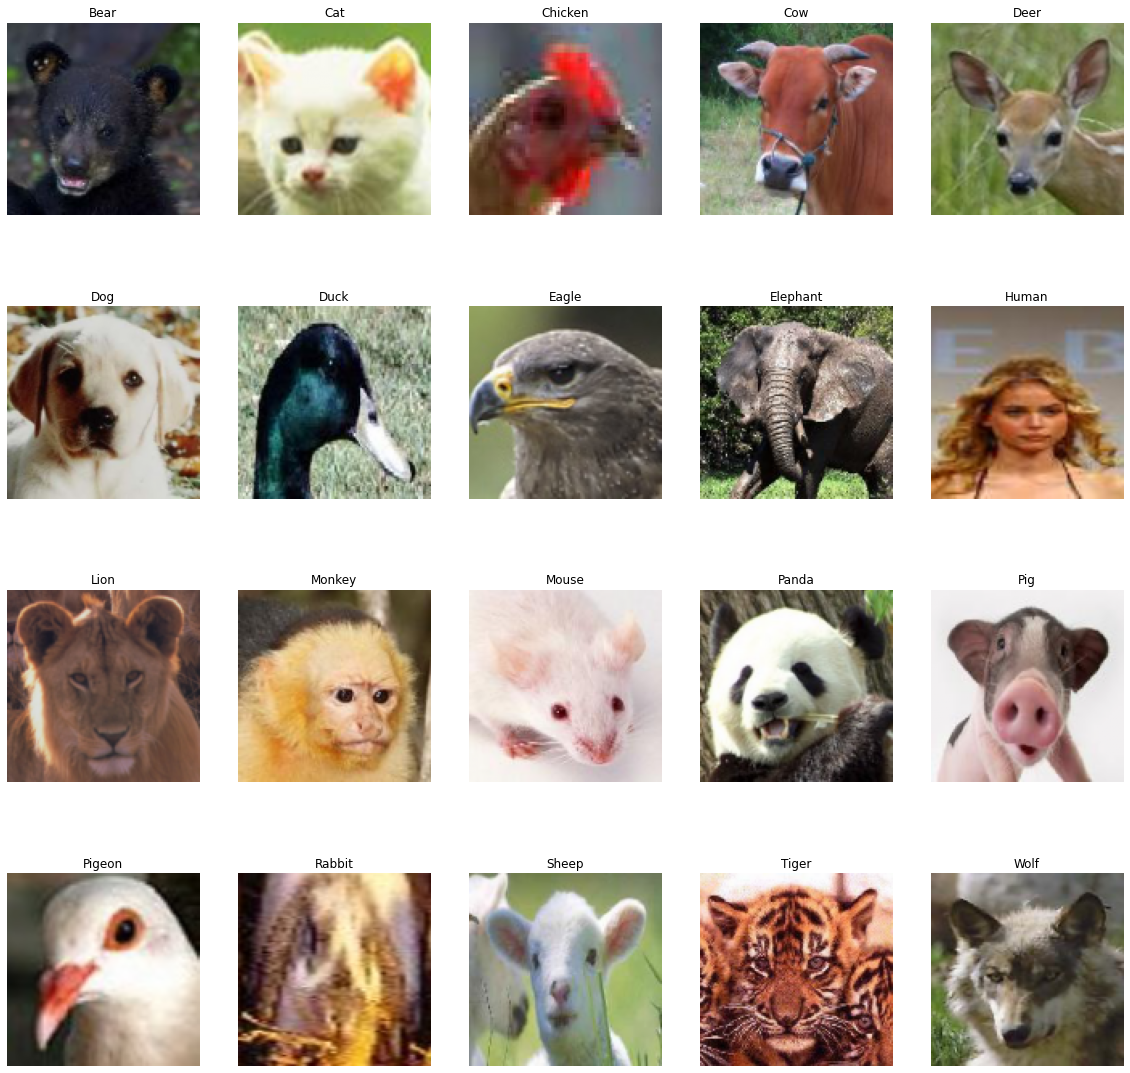

In [18]:
l_labels = np.unique(data['label'])
NB_PAR_LIGNE = 5
NB_LIGNE= len(l_labels)//NB_PAR_LIGNE + int(len(l_labels) % NB_PAR_LIGNE != False) # si l_labels % NB_PAR_LIGNE n'est pas nul, il faut rajouter une ligne
# print(l_labels, len(l_labels), NB_PAR_LIGNE, NB_LIGNE)

# Création de l'espace d'affichage
fig, axs = plt.subplots(NB_LIGNE, NB_PAR_LIGNE, figsize=(20, 20))

for i, d in enumerate(l_labels):
    ligne= i // NB_PAR_LIGNE
    colone= i % NB_PAR_LIGNE
     
    # On choisira une image au hasard appartenant à chaque groupe
    base_indice = data['label'].index(d)
    taille= data["label"].count(d)
    alea= random.randint(0,taille-1)
    #print(f"Label: {d}\tindice de base: {base_indice}\ttaille: {taille}\talea:{alea}")
    image= data["data"][data['label'].index(d)+alea]
    
    # Affichage des images
    axs[ligne,colone].imshow(image)
    axs[ligne,colone].axis('off')
    axs[ligne,colone].set_title(d)

img = imread(os.path.join("/home/jpphi/Documents/brief/brief14-Classification_Images/","coyotejp2.jpg"))

""" # Inutile si 20 classes
for i in range(1,NB_PAR_LIGNE):      # Terminons la dernière ligne !
    axs[4,i].imshow(img)
    axs[4,i].axis('off')
    axs[4,i].set_title("Vil Coyote\net Bipbip")
"""

## 6 - Diviser vos données en un ensemble de test et un ensemble de train.  
  
**Consigne**: utilisation de la fonction train_test_split de scikit-learn (80% de l'ensemble total pour 'entraînement et le reste pour l'ensemble de test).  
  
**Remarques**: Dans l'ensemble de données, les photos sont classées par animal, nous ne pouvons donc pas simplement diviser à 80%, (si les données sont ordonnées et que nous nous divisons à une certaine position, nous nous retrouverons avec certains animaux (types) apparaissant dans un seul des deux ensembles).  
Nous pouvons résoudre ce problème en mélangeant les données avant de les fractionner. De cette façon, nous égalisons les distributions dans l'ensemble de train et de test et les rendons comparables. La fonction “train_test_split” de sklearn fournit un paramètre shuffle pour prendre en charge cela tout en effectuant le fractionnement.  
“Random_state” amorce le mélange pour qu'il soit aléatoire, mais de manière reproductible.


### Test reconnaissance sans détourage
**La classe nature obtient un score de 0** ce qui provoque un warning (division par 0). Normal compte tenu du trés faible nombre d'images dans cette classe.

In [19]:
X = np.array(data['data'])
y = np.array(data['label'])

X_plat=np.array([x.ravel() for x in X])

X_train_plat, X_test_plat, y_train, y_test = train_test_split(X_plat, y, test_size=0.2, shuffle=True, random_state= 42)


In [20]:
clf_SVC = svm.SVC(kernel='linear', class_weight='balanced')
clf_SVC.fit(X_train_plat, y_train)    
#
y_pred = clf_SVC.predict(X_test_plat)
#
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))
#

Percentage correct:  54.31578947368421
              precision    recall  f1-score   support

        Bear       0.46      0.85      0.60        20
         Cat       0.33      0.54      0.41        26
     Chicken       0.96      0.83      0.89        30
         Cow       0.41      0.50      0.45        22
        Deer       0.78      0.82      0.80        22
         Dog       0.48      0.53      0.50        80
        Duck       0.53      0.45      0.49        22
       Eagle       0.50      0.50      0.50        18
    Elephant       0.42      0.24      0.30        21
       Human       0.78      0.86      0.82        21
        Lion       0.50      0.47      0.48        15
      Monkey       0.21      0.25      0.23        16
       Mouse       0.23      0.15      0.18        20
       Panda       0.92      0.92      0.92        25
         Pig       0.44      0.47      0.46        17
      Pigeon       0.44      0.50      0.47        16
      Rabbit       0.18      0.13      0.1

### Conclusion:  
Le temps de calcul est beaucoup plus long et les résultats sont mauvais (40% contre plus de 70%). Le hog est donc nécessaire!  
  
Le test a été effectué avec le fichier animal_faces_{120}x{120}px_carre_True_ct_False_nb.pkl **avec la classe nature, abandonnée depuis**.
 
Résultat obtenu:  
Percentage correct:  41.090146750524106  

      classe      precision  recall    f1-score    support

        Bear       0.55      0.81      0.65        21
         Cat       0.32      0.38      0.35        32
     Chicken       0.33      0.23      0.27        30
         Cow       0.33      0.19      0.24        21
        Deer       0.42      0.50      0.46        16
         Dog       0.54      0.55      0.54        89
        Duck       0.27      0.40      0.32        15
       Eagle       0.12      0.20      0.15        15
    Elephant       0.44      0.37      0.40        19
       Human       0.53      0.59      0.56        17
        Lion       0.33      0.12      0.17        17
      Monkey       0.19      0.28      0.23        18
       Mouse       0.28      0.21      0.24        24
     Natural       0.00      0.00      0.00         2
       Panda       0.92      0.96      0.94        24
         Pig       0.27      0.35      0.31        17
      Pigeon       0.07      0.06      0.06        17
      Rabbit       0.24      0.38      0.29        16
       Sheep       0.42      0.26      0.32        19
       Tiger       0.31      0.22      0.26        18
        Wolf       0.73      0.53      0.62        30

    accuracy                           0.41       477
    macro avg      0.36      0.36      0.35       477
    weighted avg   0.42      0.41      0.41       477


### Retour au brief, division du jeux de données

In [21]:
X = np.array(data['data'])
y = np.array(data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state= 51165)

## 7 - Vérifier que la distribution des photos dans l'ensemble de formation et de test est similaire.  
* Examiner le nombre relatif de photos par catégorie.
* Que pensez-vous des distributions ?
    - Les distributions sont homogènes à l'exeption de la classe dog sur-représenté et de la classe natural très largement sous représentée. Cela risque de poser un problème lors de l'apprentissage. Si les chiens sont correctement détecté (voir plus loin) un certain nombre d'autre animaux sont classé dans cette catégorie (beaucoup de "faux positif").
* Existe-t-il un moyen de s’assurer de l’obtention de distributions égales dans l'ensemble d'apprentissage et de test ?
    -  Nous inclueront dans l'algo d'apprentissage un paramètre indiquant qu'il doit "pondérer" les classes pour éviter ce sur-apprentissage de la classe chien. La classe natural devra être compléter (plus tard) par l'ajout de nouvelles photos appartenant à cette classe. Une autre possibilitée serait de limiter artificiellement la classe chien....


### Fonction d'affichage relatif et absolue du nombre d'échantillons  
On note que **certaines classes** (chicken, cow, duck et wolf notament) **ont une représentation plus forte** que leur nombre effectif (%test > %effectif). Pour **d'autres classe, c'est l'inverse**. Ceci pourrait poser un **problème de sur aprentissage / sous aprentissage**. À surveiller! 

### Affichage en valeurs relatives

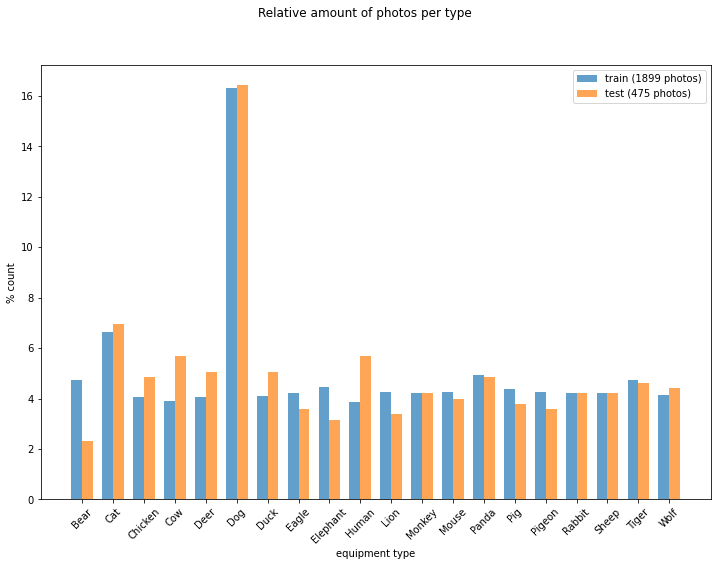

In [22]:
plt.figure(figsize=(12,8))
plt.suptitle('Relative amount of photos per type')
b17fonctions.plot_bar(y_train, loc='left')
b17fonctions.plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);


### Affichage en valeurs absolus

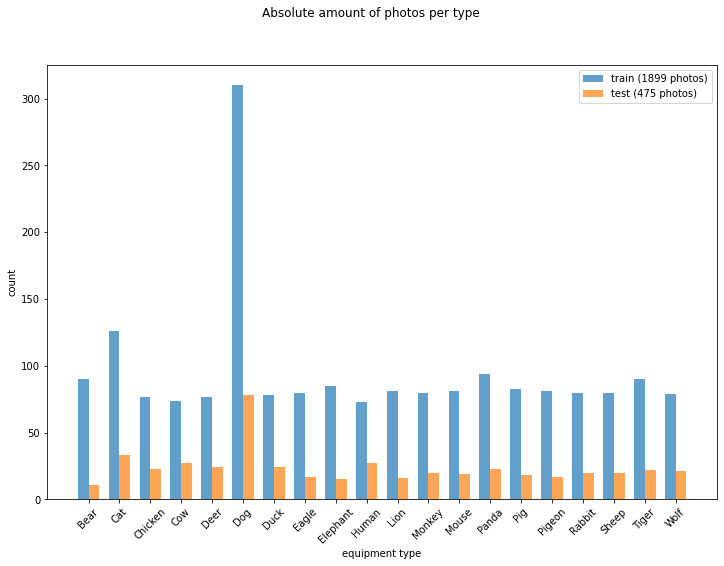

In [23]:
plt.figure(figsize=(12,8))
plt.suptitle('Absolute amount of photos per type')
b17fonctions.plot_bar(y_train, loc='left', relative=False)
b17fonctions.plot_bar(y_test, loc='right', relative=False)
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);


## 8 - Traitement des données  
Une approche classique de la reconnaissance d'objets est HOG-SVM, qui signifie Histogramme des dégradés orientés (Histogram of Oriented Gradients) et Support Vector
Machines. Les HOG sont utilisés pour la réduction des caractéristiques, en d'autres termes :  
pour réduire la complexité du problème, tout en conservant autant de variations que possible.  
Pour calculer un HOG, une image est divisée en blocs, par exemple 8 par 8 pixels. Pour chacun de ces blocs, la magnitude du gradient dans un nombre donné de directions
est calculée. Pour une explication détaillée, vous pouvez vous référer à ce tutoriel :  
* http://www.learnopencv.com/histogram-of-oriented-gradients

Par exemple sur l’image ci-dessous, si l’on réduit l’image à un tier, puis que l’on calcule le HOG, on pourra renvoyer une représentation visuelle comme celle-ci :  
    ![Image](img2_cours.png)  
  
Le nombre de points de données à traiter dans notre modèle a été réduit à ~ 15%, et avec un peu d'imagination, nous pouvons encore reconnaître un chien dans le HOG. 
  
Lors du calcul du HOG, nous effectuons une transformation. Nous pouvons transformer l'ensemble de notre ensemble de données à l'aide de transformateurs. Les transformateurs sont des objets qui se servent dans le tableau de données, transforment chaque élément et renvoient les données résultantes.  
Ici, nous devons convertir les images couleur en niveaux de gris, calculer leurs HOG et enfin mettre à l'échelle les données. Pour cela, nous utilisons trois transformateurs à la suite:
* RGB2GrayTransformer,
* HOGTransformer
* StandardScaler.  
  
Le résultat final est un tableau avec un HOG pour chaque image de l'entrée.  
  
Scikit-learn est livré avec de nombreux transformateurs intégrés, tels qu'un StandardScaler pour mettre à l'échelle des entités et un Binarizer pour mapper des entités de chaîne à des entités numériques. De plus, il fournit les classes BaseEstimator et TransformerMixin pour faciliter la création de vos propres Transformers.  
  
 Un transformateur personnalisé peut être créé en héritant de ces deux classes (BaseEstimator, TransformerMixin) et en implémentant une méthode \__init__, fit() et transform(). La classe TransformerMixin fournit la méthode fit_transform(), qui combine l'ajustement et la transformation que nous avons implémentés.  
 
Créer vos classes RGB2GrayTransformer and HOGTransformer.  
Après avoir instancié chaque transformateur (RGB2GrayTransformer(), HogTransformer(), StandardScaler()), mettez à l’échelle votre échantillon de données en appelant fit_transform() à chaque transformation en convertissant X_train étape par étape (RGB2GrayTransformer, puis HogTransformer, puis StandardScaler).

hog:   https://learnopencv.com/histogram-of-oriented-gradients/

### Cours du tutoriel sur le hog

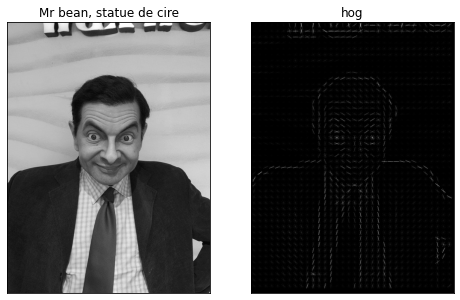

In [24]:
img = imread('mr-bean-671027_640.jpg', as_gray= True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# On laisse à la même taille, cette commande modifie le rendu du hog même sans redimensionnement.... mode reflect à voir
img = rescale(img, 1, mode='reflect')

# calculate the hog and return a visual representation.
img_hog, img_hog_img = hog(
    img, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]
 
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Mr bean, statue de cire')
ax[1].imshow(img_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [25]:
print(f"Shape de l'image : {img.shape[0]} * {img.shape[1]} et taille {img.shape[0] * img.shape[1]}")
print('number of hog features: ', img_hog.shape[0])

Shape de l'image : 640 * 480 et taille 307200
number of hog features:  52272


### Hog d'un RGB  

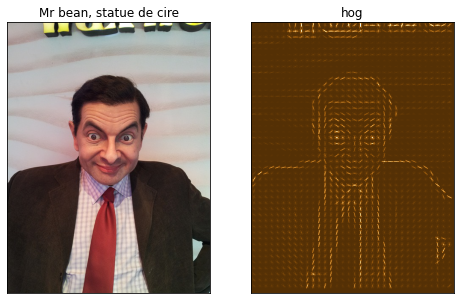

In [26]:
img = imread('mr-bean-671027_640.jpg')
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# On laisse à la même taille, cette commande modifie le rendu du hog même sans redimensionnement.... mode reflect à voir
img = rescale(img, 1, mode='reflect')

# calculate the hog and return a visual representation.
img_hog, img_hog_img = hog(
    img, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)

# remove ticks and their labels
b= [a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]
# b contient [None,None] ...
# On boucle sur les ax, (ax[0], ax[1]) et pour chacun on applique la méthode tick_params
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tick_params.html
# bottom=False, left=False, supprime les petites barres
# labelbottom=False, labelleft=False, supprimes les label (0, 100, 200, ...)

ax[0].imshow(img, cmap='BrBG')
ax[0].set_title('Mr bean, statue de cire')
ax[1].imshow(img_hog_img, cmap='BrBG')
ax[1].set_title('hog')
plt.show()

### Retour au brief
Le code ci-dessous est directement issue du brief

In [27]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [28]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 

In [29]:
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(1899, 1764)


In [30]:
# Même procédure que précédemment pour X_test.... step by step!
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

print(X_test_prepared.shape)

(475, 1764)


## 9 - Entraîner un classifieur.  
Test de quelques classifier. Le SVC semble être le meilleur.


In [31]:
sgd_clf = SGDClassifier(random_state= 51165, max_iter=500, tol=1e-3, class_weight= "balanced")
sgd_clf.fit(X_train_prepared, y_train)

# Percentage correct:  62.0545073375262 avec le set 80x80 sans modification
y_pred = sgd_clf.predict(X_test_prepared)

#print(np.array(y_pred == y_test)[:25])
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))

Percentage correct:  72.63157894736842
              precision    recall  f1-score   support

        Bear       0.41      0.64      0.50        11
         Cat       0.70      0.85      0.77        33
     Chicken       0.88      0.65      0.75        23
         Cow       0.83      0.70      0.76        27
        Deer       0.80      0.67      0.73        24
         Dog       0.74      0.73      0.74        78
        Duck       0.81      0.71      0.76        24
       Eagle       0.93      0.76      0.84        17
    Elephant       0.67      0.53      0.59        15
       Human       1.00      0.93      0.96        27
        Lion       0.56      0.88      0.68        16
      Monkey       0.89      0.80      0.84        20
       Mouse       0.56      0.53      0.54        19
       Panda       0.89      0.70      0.78        23
         Pig       0.38      0.56      0.45        18
      Pigeon       0.85      1.00      0.92        17
      Rabbit       0.48      0.60      0.5

In [32]:
clf_SVC = svm.SVC(kernel='linear', class_weight='balanced')
clf_SVC.fit(X_train_prepared, y_train)    

y_pred = clf_SVC.predict(X_test_prepared)

print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))

Percentage correct:  77.89473684210526
              precision    recall  f1-score   support

        Bear       0.44      0.73      0.55        11
         Cat       0.66      0.94      0.78        33
     Chicken       0.89      0.74      0.81        23
         Cow       0.89      0.59      0.71        27
        Deer       0.88      0.88      0.88        24
         Dog       0.75      0.78      0.77        78
        Duck       0.89      0.71      0.79        24
       Eagle       1.00      0.76      0.87        17
    Elephant       0.91      0.67      0.77        15
       Human       1.00      0.93      0.96        27
        Lion       0.71      0.94      0.81        16
      Monkey       0.94      0.80      0.86        20
       Mouse       0.72      0.68      0.70        19
       Panda       0.89      0.74      0.81        23
         Pig       0.52      0.61      0.56        18
      Pigeon       0.89      1.00      0.94        17
      Rabbit       0.63      0.60      0.6

In [33]:
gnb = GaussianNB()
gnb.fit(X_train_prepared, y_train)
y_pred = gnb.predict(X_test_prepared)

print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))

cmx = confusion_matrix(y_test, y_pred)


Percentage correct:  74.52631578947368
              precision    recall  f1-score   support

        Bear       0.43      0.55      0.48        11
         Cat       0.76      0.85      0.80        33
     Chicken       0.86      0.78      0.82        23
         Cow       0.83      0.70      0.76        27
        Deer       0.84      0.88      0.86        24
         Dog       0.81      0.60      0.69        78
        Duck       0.86      0.79      0.83        24
       Eagle       0.93      0.76      0.84        17
    Elephant       0.73      0.73      0.73        15
       Human       1.00      0.93      0.96        27
        Lion       0.61      0.88      0.72        16
      Monkey       0.71      0.85      0.77        20
       Mouse       0.62      0.53      0.57        19
       Panda       0.83      0.83      0.83        23
         Pig       0.42      0.56      0.48        18
      Pigeon       0.89      0.94      0.91        17
      Rabbit       0.41      0.60      0.4

In [34]:
from sklearn.naive_bayes import BernoulliNB

clfB = BernoulliNB()
clfB.fit(X_train_prepared, y_train)

#clfCat = CategoricalNB()
#clfCat.fit(X_train_prepared, y_train)


#clfMulti = MultinomialNB()
#clfMulti.fit(X_train_prepared, y_train)

y_pred = clfB.predict(X_test_prepared)

print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))

#cmx = confusion_matrix(y_test, y_pred)


Percentage correct:  71.15789473684211
              precision    recall  f1-score   support

        Bear       0.40      0.55      0.46        11
         Cat       0.74      0.88      0.81        33
     Chicken       0.76      0.70      0.73        23
         Cow       0.78      0.78      0.78        27
        Deer       0.78      0.88      0.82        24
         Dog       0.80      0.55      0.65        78
        Duck       0.82      0.58      0.68        24
       Eagle       0.72      0.76      0.74        17
    Elephant       0.65      0.73      0.69        15
       Human       1.00      0.89      0.94        27
        Lion       0.54      0.94      0.68        16
      Monkey       0.85      0.85      0.85        20
       Mouse       0.50      0.47      0.49        19
       Panda       0.82      0.78      0.80        23
         Pig       0.41      0.50      0.45        18
      Pigeon       0.71      0.88      0.79        17
      Rabbit       0.35      0.40      0.3

### Paramètre class_weight sur le sgdc classifier  
Permet de metttre en valeur les problème de sur apprentissage d'une classe sur repprésenté. Avec cette option, le classifier devrai en tenir compte et régler ce problème... mais il ne le fais que partiellement
  
**Dans le brief, c'est le fichier 120x120 carré qui a été sélectionné**
Pour le SGDClassifier(random_state=42, max_iter=1000, tol=1e-3, class_weight= "balanced")
  
**Résultat sur les données issus du fichier 80x80 sans aucune retouche**.  
Percentage correct:  62.0545073375262
  
precision    recall  f1-score   support

        Bear       0.59      0.62      0.60        21
         Cat       0.77      0.59      0.67        34
     Chicken       0.77      0.71      0.74        28
         Cow       0.62      0.40      0.49        25
        Deer       0.67      0.62      0.65        16
         Dog       0.46      0.73      0.57        81
        Duck       0.82      0.64      0.72        28
       Eagle       0.88      0.79      0.83        19
    Elephant       0.69      0.52      0.59        21
       Human       0.82      0.64      0.72        14
        Lion       0.50      0.69      0.58        13
      Monkey       0.60      0.56      0.58        16
       Mouse       0.43      0.53      0.48        19
     Natural       0.00      0.00      0.00         2
       Panda       1.00      0.77      0.87        22
         Pig       0.30      0.35      0.32        17
      Pigeon       0.87      0.76      0.81        17
      Rabbit       0.80      0.71      0.75        17
       Sheep       0.22      0.21      0.22        19
       Tiger       0.88      0.83      0.86        18
        Wolf       0.76      0.53      0.63        30

    accuracy                           0.62       477
   macro avg       0.64      0.58      0.60       477
weighted avg       0.65      0.62      0.63       477
  
Pour le SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
  
Percentage correct:  61.0062893081761
  
 precision    recall  f1-score   support

        Bear       0.61      0.52      0.56        21
         Cat       0.81      0.65      0.72        34
     Chicken       0.77      0.61      0.68        28
         Cow       0.77      0.40      0.53        25
        Deer       0.77      0.62      0.69        16
         Dog       0.38      0.85      0.53        81
        Duck       0.89      0.57      0.70        28
       Eagle       0.94      0.79      0.86        19
    Elephant       0.71      0.48      0.57        21
       Human       1.00      0.57      0.73        14
        Lion       0.44      0.54      0.48        13
      Monkey       0.80      0.50      0.62        16
       Mouse       0.53      0.42      0.47        19
     Natural       0.00      0.00      0.00         2
       Panda       1.00      0.73      0.84        22
         Pig       0.27      0.24      0.25        17
      Pigeon       0.85      0.65      0.73        17
      Rabbit       0.86      0.71      0.77        17
       Sheep       0.38      0.26      0.31        19
       Tiger       0.93      0.78      0.85        18
        Wolf       0.90      0.60      0.72        30

    accuracy                           0.61       477
   macro avg       0.70      0.55      0.60       477
weighted avg       0.69      0.61      0.62       477


## 10 - Évaluer les faux positifs grâce à une matrice de confusion.  
On prend le meilleur classifier, le SVC


Percentage correct:  77.89473684210526
              precision    recall  f1-score   support

        Bear       0.44      0.73      0.55        11
         Cat       0.66      0.94      0.78        33
     Chicken       0.89      0.74      0.81        23
         Cow       0.89      0.59      0.71        27
        Deer       0.88      0.88      0.88        24
         Dog       0.75      0.78      0.77        78
        Duck       0.89      0.71      0.79        24
       Eagle       1.00      0.76      0.87        17
    Elephant       0.91      0.67      0.77        15
       Human       1.00      0.93      0.96        27
        Lion       0.71      0.94      0.81        16
      Monkey       0.94      0.80      0.86        20
       Mouse       0.72      0.68      0.70        19
       Panda       0.89      0.74      0.81        23
         Pig       0.52      0.61      0.56        18
      Pigeon       0.89      1.00      0.94        17
      Rabbit       0.63      0.60      0.6

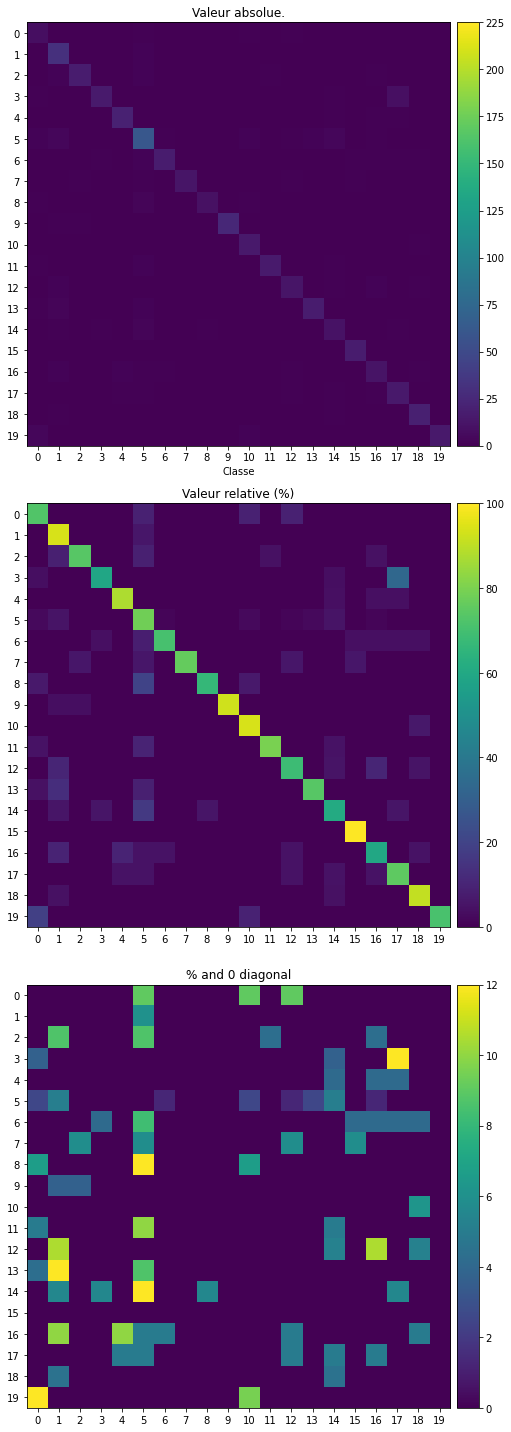

In [35]:
clf_SVC = svm.SVC(kernel='linear', class_weight='balanced')
clf_SVC.fit(X_train_prepared, y_train)    

y_pred = clf_SVC.predict(X_test_prepared)

print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))

#print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))

cmx = confusion_matrix(y_test, y_pred)
b17fonctions.plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)
print(cmx)

### Les différentes classes ordonnées par précision:  
**La classe nature a été supprimé depuis**
  
    Human  	100,00 %	93,00 %	96,00 %	14
    Pigeon 	100,00 %	82,00 %	90,00 %	17
    Wolf   	 96,00 %	80,00 %	87,00 %	30
    Panda  	 95,00 %	86,00 %	90,00 %	22
    Tiger  	 94,00 %	94,00 %	94,00 %	18
    Elephant	89,00 %	76,00 %	82,00 %	21
    Duck   	 87,00 %	71,00 %	78,00 %	28
    Chicken	 85,00 %	82,00 %	84,00 %	28
    Eagle  	 81,00 %	89,00 %	85,00 %	19
    Rabbit 	 79,00 %	65,00 %	71,00 %	17
    Monkey 	 77,00 %	62,00 %	69,00 %	16
    Deer   	 76,00 %	81,00 %	79,00 %	16
    Cat    	 75,00 %	88,00 %	81,00 %	34
    Mouse  	 70,00 %	74,00 %	72,00 %	19
    Dog     	66,00 %	77,00 %	71,00 %	81
    Cow     	60,00 %	60,00 %	60,00 %	25
    Bear    	59,00 %	76,00 %	67,00 %	21
    Sheep   	57,00 %	42,00 %	48,00 %	19
    Pig     	54,00 %	41,00 %	47,00 %	17
    Lion    	43,00 %	69,00 %	53,00 %	13
    Natural	  0,00 %	 0,00 %	 0,00 %	 2



## 11 - Mettre en place un pipeline qui pré-traite les données.  
(RGB2GrayTransformer(), HogTransformer(), StandardScaler()), entraîne le modèle et nous permet de modifier
les paramètres plus facilement.  
En utilisant un pipeline, nous pouvons optimiser à la fois les transformations et le classificateur en une seule procédure. De plus, au lieu de modifier manuellement les
paramètres, nous pouvons utiliser un GridSearchCV.


In [36]:
# Diffcile de comprendre comment les paramètres sont ensuite passé au HogTransformer depuis l'autre pipe...
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', svm.SVC(kernel='linear', class_weight='balanced'))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


#SGDClassifier(random_state=42, max_iter=1000, tol=1e-3, class_weight= "balanced") # résultat: 69.39%

Percentage correct:  77.89473684210526


## 12 - Pour cela, définir une grille de paramètres (param_grid = [{...}]).  
**Attention au temps de calcul!**  
  


In [37]:

param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3),(4, 4)],
        'hogify__pixels_per_cell': [(5, 5),(7, 7), (8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3,class_weight= "balanced"),
             svm.SVC(kernel='linear',class_weight= "balanced"),
             BernoulliNB()
         ]
    }
]



## 13 - Évaluer dans le même objet Grid Search, le classifieur SGD, le classifieur SVM, ainsi qu’un classifieur Naïve Bayes.  
Une fois le Grid Search terminé, le modèle sera entraîné une dernière fois, en utilisant l'ensemble complet d'apprentissage et les paramètres optimaux.
Que pouvez-vous conclure de ces modèles, en étudiant le fonctionnement intrinsèque du SVM et du Naive Bayes, est-on capable d’anticiper quel algorithme sera le
plus efficace pour cette tâche de classification d’images ?


### **Attention au temps d'exécution**

In [38]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs= 1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 33 candidates, totalling 99 fits


In [39]:
grid_res

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                                       ('hogify',
                                        HogTransformer(cells_per_block=(2, 2),
                                                       pixels_per_cell=(14,
                                                                        14))),
                                       ('scalify', StandardScaler()),
                                       ('classify',
                                        SVC(class_weight='balanced',
                                            kernel='linear'))]),
             n_jobs=1,
             param_grid=[{'hogify__cells_per_block': [(2, 2), (3, 3), (4, 4)],
                          'hogify__orientations': [8, 9],
                          'hogify__pixels_per_cell': [(5, 5), (7, 7), (8, 8),
                                                      (10, 10), (12, 12)]},
                         {'classify': [SGDClassifier

In [40]:
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(pixels_per_cell=(10, 10))),
                ('scalify', StandardScaler()),
                ('classify', SVC(class_weight='balanced', kernel='linear'))])

In [41]:
grid_res.best_score_

0.7761979989468141

In [43]:
grid_res.best_params_

{'hogify__cells_per_block': (3, 3),
 'hogify__orientations': 9,
 'hogify__pixels_per_cell': (10, 10)}

## 14 - Évaluer les résultats des modèles (avec paramètres optimaux calculés par le Grid Search).  
Quel classifieur offre de meilleurs scores pour cette tâche ?  
**Compilation des résultats des calculs ci-dessus:**


In [44]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  81.6842105263158


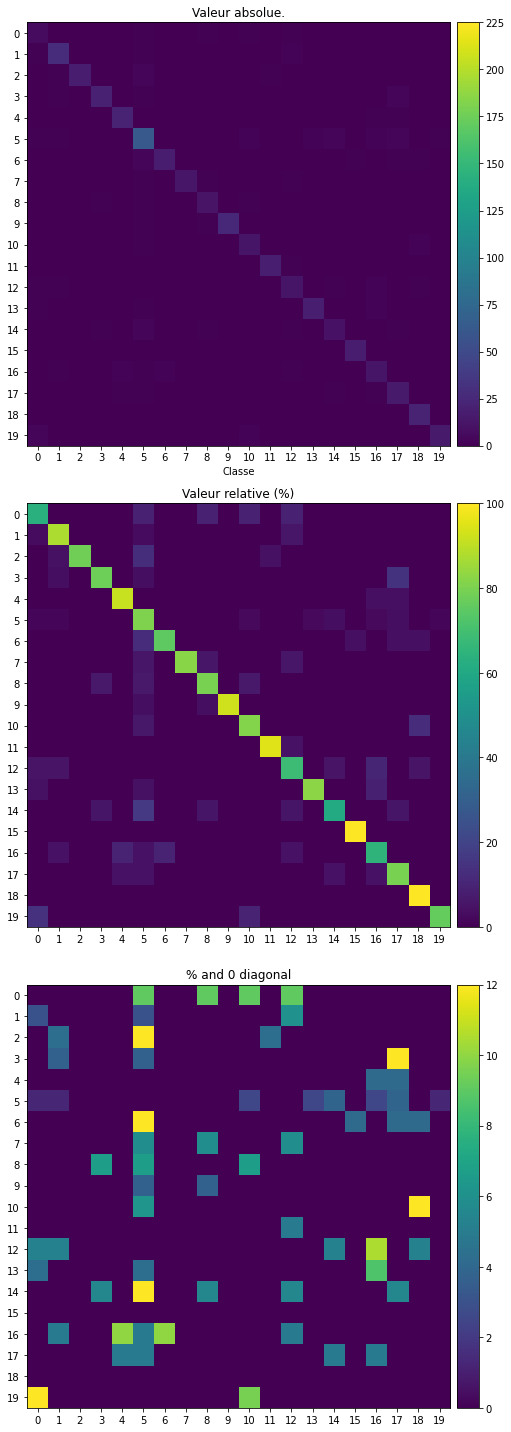

In [45]:
cmx = confusion_matrix(y_test, best_pred)

b17fonctions.plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

In [46]:
print(cmx)

[[ 7  0  0  0  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0]
 [ 1 29  0  0  0  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1 18  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0 21  0  1  0  0  0  0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0]
 [ 1  1  0  0  0 63  0  0  0  0  2  0  0  2  3  0  2  3  0  1]
 [ 0  0  0  0  0  3 18  0  0  0  0  0  0  0  0  1  0  1  1  0]
 [ 0  0  0  0  0  1  0 14  1  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0 12  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  1 25  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0 13  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0  0 13  0  1  0  2  0  1  0]
 [ 1  0  0  0  0  1  0  0  0  0  0  0  0 19  0  0  2  0  0  0]
 [ 0  0  0  1  0  3  0  0  1  0  0  0  1  0 11  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0

In [47]:
print(classification_report(y_test, best_pred, target_names= np.unique(y_test)))

              precision    recall  f1-score   support

        Bear       0.50      0.64      0.56        11
         Cat       0.85      0.88      0.87        33
     Chicken       1.00      0.78      0.88        23
         Cow       0.91      0.78      0.84        27
        Deer       0.88      0.92      0.90        24
         Dog       0.77      0.81      0.79        78
        Duck       0.90      0.75      0.82        24
       Eagle       1.00      0.82      0.90        17
    Elephant       0.75      0.80      0.77        15
       Human       1.00      0.93      0.96        27
        Lion       0.68      0.81      0.74        16
      Monkey       0.95      0.95      0.95        20
       Mouse       0.65      0.68      0.67        19
       Panda       0.90      0.83      0.86        23
         Pig       0.69      0.61      0.65        18
      Pigeon       0.94      1.00      0.97        17
      Rabbit       0.62      0.65      0.63        20
       Sheep       0.62    

## 15 - Enregistrer vos résultats dans un fichier pickle (joblib).  
Afin de pouvoir recharger les résultats lorsque vous en aurez besoin (par ex avec Heroku).


In [48]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl');

# Zone Bonus :)

## 16 - Créer votre propre dataset avec des images provenant de Google Image.  
Appliquer votre pipeline sur ce nouveau jeu de données. Au besoin, relancer un Grid Search.  
  
Télécharger l'add on pour Chrome Image Downloader sur Google Store


In [49]:
d_data_externe={'description': [],'label': [], 'filename': [],'data': []}
srep_racine = fr'{os.getenv("HOME")}/Documents/brief/brief14-Classification_Images/data/img_scrap'
l_rep_data= os.listdir(srep_racine) # Liste contenant le nom de tout les sous répertoires qui contiennent les images

print(f"Répertoires contenant les différents images:\n{l_rep_data}")
#creatpkl(d_data_externe, l_rep_data, largeurimg= largeur, hauteurimg= hauteur)

Répertoires contenant les différents images:
['Bear']


<ipython-input-27-5193a0b672d6>:15: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X])


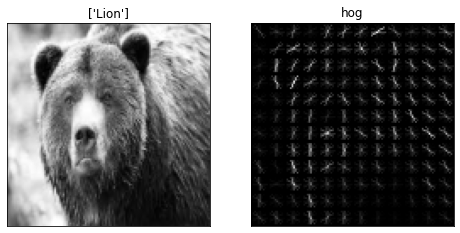

In [50]:
img = imread('./data/img_scrap/Bear/bearheadgoogle022.jpg', as_gray= True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
img = resize(img, (120, 120)) #[:,:,::-1]
 
# On laisse à la même taille, cette commande modifie le rendu du hog même sans redimensionnement.... mode reflect à voir
img = rescale(img, 1, mode='reflect')

# calculate the hog and return a visual representation.
img_hog, img_hog_img = hog(
    img, pixels_per_cell=(10,10), 
    cells_per_block=(3, 3), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')

test= np.array([img])
label = grid_res.predict(test)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]
 
ax[0].imshow(img, cmap='gray')
ax[0].set_title(label)
ax[1].imshow(img_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()


In [51]:
img.shape

(120, 120)

### Voir si détection possible sur des représentation de type dessins, peluche,...

## 17 - Développer une interface utilisateur (Dash).  
Elle devra permettre de charger une image, puis de retourner le label de l’image (la classe).


## 18 - Quelles seraient les adaptations à faire pour offrir un logiciel de labellisation automatique ?  
Proposer un cahier des charges précis. Proposer une implémentation (une mise en œuvre). Réfléchir à la manière la plus appropriée de stocker les libellés
des images afin que ceux-ci soient indépendant de l’application sur


## 19 - Après avoir réalisé une veille sur les tests unitaires, fonctionnels, de non-régression.  
Programmer vos tests unitaires et fonctionnels.


## 20 - Finalisation:  
Afin de trouver facilement les images qui lui permettront d’appuyer ces présentations pédagogiques aux enfants de sa classe, votre ami souhaite une application similaire à
Google Image dédiée à ses images contenues sur son disque dur. Que pouvez-vous luiproposer ? Quelles sont les types d’algorithmes qui permettent de réaliser ce type
d’application ?


## 21 - Réfléchir à une solution de stockage des images.


## 22 - Programmer votre propre application Google Image !!!!

# HORS BRIEF - Bout de code

## Méta-données

In [ ]:
# Tagger les images dans les méta données

# Échec les métadonnées semble trés structuré et impossible d'ajouter un élément de type "label"

from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

toto = PIL.Image.open('toto.jpg')
exif_data = toto._getexif()
print(exif_data)
print(exif_data.items())

print(TAGS[0x010e])

#import EXIF
from exif import Image

with open('toto.jpg', 'rb') as image_file:
    my_image = Image(image_file)

print(dir(my_image))
print(my_image.has_exif)

with open('modified_image.jpg', 'wb') as new_image_file:
    new_image_file.write(my_image.get_file())

## Scraper: à approfondir

https://www.parsehub.com/blog/scrape-images-website/

https://www.linux-apps.com/p/1304856/
  
https://askubuntu.com/questions/510340/google-books-downloader-for-ubuntu  
  
Image Downloader sur Google Store

Download All Images

Pipeline  
https://github.com/bmurauer/pipelinehelper

### flask:  
    
https://towardsdatascience.com/a-flask-app-for-image-recommendations-a865e1496a0d  
    
https://stackoverflow.com/questions/24977071/open-image-from-online-save-to-server-flask
      

## bout de code

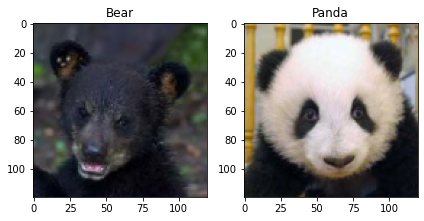

In [52]:
### Exemple d'images du dataset
fig, axes = plt.subplots(nrows=1, ncols=2)
n1, n2= 106, 106+404
img1= data["data"][n1]
tag1= data["label"][n1]
img2= data["data"][n2]
tag2= data["label"][n2]
axes[0].imshow(img1, cmap='BrBG')
axes[0].set_title(tag1)
axes[1].imshow(img2, cmap='BrBG')
axes[1].set_title(tag2)
plt.tight_layout()
plt.show()